In [1]:
import matplotlib.pyplot as plt, numpy as np, seaborn as sns, scipy.stats as stats, pandas as pd, os, glob
import ast
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## load df and check

In [10]:
subjs = ['jamie', 'adam', 'tori']

df = pd.DataFrame()
for subj in subjs:
    df_subj = pd.read_csv(glob.glob(f'../results/formatted/*{subj}*.csv')[0])[:-1]
    df = pd.concat([df, df_subj], ignore_index=True)

df.to_csv('../results/formatted/new_combined_subjs.csv', index=False)

## filtering df

In [11]:
# 1.
print(df['correct'].value_counts(normalize=False))
print(df['outcome'].value_counts(normalize=False))
print(df['outcome'].value_counts(normalize=False))


# 2.
for col in ['positions']:
    if type(df[col][0]) == str:
        df[col] = df[col].apply(lambda x: ast.literal_eval(x)) # convert str to list

# 3. # MAE = dist between target & last position
df['MAE_unnormed'] = abs(df['target_pos'] - df['positions'].apply(lambda x: x[-1]))
df['MAE_normed'] = np.where(
    ((df['condition'] == 'pen_comp') & (df['valence'] == 'pen')) | ((df['condition'] == 'rew_comp') & (df['valence'] == 'rew')),
    df['MAE_unnormed']*2, 
    df['MAE_unnormed']
)
# 4.
df['dist'] = df['positions'].apply(lambda x: abs(x[-1] - x[0]))
df['avg_speed'] = df['dist'] / df['trials.submit_resp.rt']

# 5.
df['choice'] = df['outcome'].apply(lambda x: 1 if abs(x) == 2 else 0 if abs(x) == 1 else 0)
# df = df[df['choice'] != 0]

# 6.
# filtering out easy trials
hard_thresh = .05
df_hard = df[df['target_pos'] - df['div_pos'] <= hard_thresh].copy()
print(f'% trials with |target-divider| <= {hard_thresh}: {len(df_hard)/len(df)}')

correct
1.0    603
0.0    117
Name: count, dtype: int64
outcome
 2.0    313
 1.0    290
-2.0     52
-1.0     37
 0.0     28
Name: count, dtype: int64
outcome
 2.0    313
 1.0    290
-2.0     52
-1.0     37
 0.0     28
Name: count, dtype: int64
% trials with |target-divider| <= 0.05: 0.5666666666666667


## 1. analyses by valence and compression

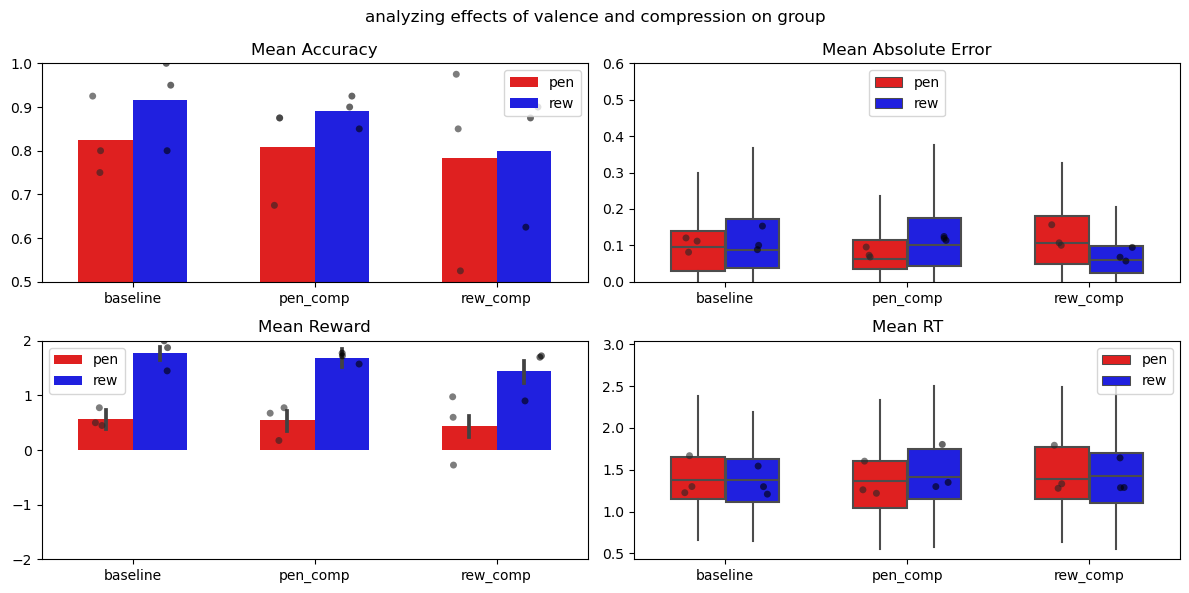

In [12]:
df_plot = df.copy()
# df_plot = df_hard.copy()


fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()
fig.suptitle('analyzing effects of valence and compression on group')
order, hue_order, palette = df.condition.unique(), ['pen', 'rew'], {'pen': 'red', 'rew': 'blue'}

# DOUBLE CHECK ALL THESE PLOTS
# 1. accuracy
ax = axes[0]
sns.barplot(data=df_plot, x='condition', y='correct', hue='valence',
            order = order, hue_order = hue_order, palette = palette, width=0.6, ax=ax, errorbar=None)

group_df = df_plot.groupby(['subj', 'condition', 'valence'])['correct'].mean().reset_index()
sns.stripplot(data=group_df, x='condition', y='correct', hue='valence', 
              order = order, hue_order = hue_order, color = 'black', dodge=True, alpha=0.6, jitter=True, legend=False, ax=ax)

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(.5, 1)
ax.set_title('Mean Accuracy')
ax.legend()


# 2. MAE
ax = axes[1]
sns.boxplot(data=df_plot, x='condition', y='MAE_unnormed', hue='valence',
            order = order, hue_order = hue_order, palette = palette, showcaps=False, fliersize=0, width=0.6, ax=ax)

group_df = df_plot.groupby(['subj', 'condition', 'valence'])['MAE_unnormed'].mean().reset_index()
sns.stripplot(data=group_df, x='condition', y='MAE_unnormed', hue='valence', 
              order = order, hue_order = hue_order, color = 'black', dodge=True, alpha=0.6, jitter=True, legend=False, ax=ax)

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(0, .6)
ax.set_title('Mean Absolute Error')
# SOMETHING IS OFF HERE WITH THE LOGIC; SHOULDNT NORMALIZING ON THE EXPANDED SIDE BE DEPENDENT ON SAMPLING POSITION?
# AM I BEING TOO CONSRVATIVE WITH THE NORMALIZATION = .4?
ax.legend()


# 3. reward
ax = axes[2]
sns.barplot(data=df_plot, x='condition', y='outcome', hue='valence',
            order = order, hue_order = hue_order, palette = palette, width=0.6, ax=ax)

group_df = df_plot.groupby(['subj', 'condition', 'valence'])['outcome'].mean().reset_index()
sns.stripplot(data=group_df, x='condition', y='outcome', hue='valence',
              order = order, hue_order = hue_order, color = 'black', dodge=True, alpha=0.6, jitter=True, legend=False, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(-2, 2)
ax.set_title('Mean Reward')
ax.legend()


# 4. RT
ax = axes[3]
sns.boxplot(data=df_plot, x='condition', y='trials.submit_resp.rt', hue='valence',
            order = order, hue_order = hue_order, palette = palette, showcaps=False, fliersize=0, width=0.6, ax=ax)

group_df = df_plot.groupby(['subj', 'condition', 'valence'])['trials.submit_resp.rt'].mean().reset_index()
sns.stripplot(data=group_df, x='condition', y='trials.submit_resp.rt', hue='valence',
              order = order, hue_order = hue_order, color = 'black', dodge=True, alpha=0.6, jitter=True, legend=False, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Mean RT')
ax.legend()


plt.tight_layout()
plt.show()

## 2. analyses by perceptual space

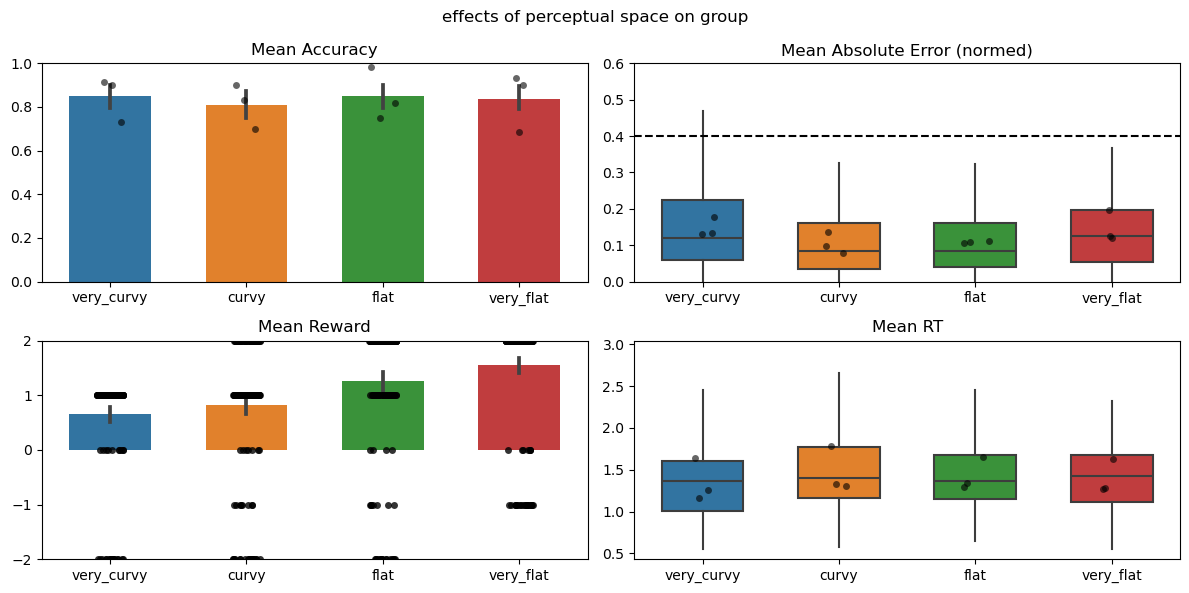

In [14]:
df_plot = df.copy()

conditions = [
    (-0.4 < df_plot['stim_pos']) & (df_plot['stim_pos'] < -0.2),
    (-0.2 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0),
    (0 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0.2),
    (0.2 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0.4)
]
percept_labels = ['very_curvy', 'curvy', 'flat', 'very_flat']
df_plot['percept_space'] = np.select(conditions, percept_labels)

# probably need to flip perceptual axis for salma and some other pilots

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()
fig.suptitle('effects of perceptual space on group')

# 1. accuracy
ax = axes[0]
sns.barplot(data=df_plot, x='percept_space', y='correct', order = percept_labels, width=0.6, ax=ax)

group_df = df_plot.groupby(['subj', 'percept_space'])['correct'].mean().reset_index()
sns.stripplot(data=group_df, x='percept_space', y='correct', order = percept_labels, color='black', dodge=True, alpha=0.6, jitter=True, legend=False, ax=ax)

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(0, 1)
ax.set_title('Mean Accuracy')
ax.set_xticklabels(percept_labels)

# 2. MAE
ax = axes[1]
sns.boxplot(data=df_plot, x='percept_space', y='MAE_normed', order = percept_labels, showcaps=False, fliersize=0, width=0.6, ax=ax)

group_df = df_plot.groupby(['subj', 'percept_space'])['MAE_normed'].mean().reset_index()
sns.stripplot(data=group_df, x='percept_space', y='MAE_normed', order = percept_labels, color='black', dodge=True, alpha=0.6, jitter=True, legend=False, ax=ax)

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(0, .6)
ax.axhline(y=.4, color='black', linestyle='--', label = 'max error on correct side')
ax.set_title('Mean Absolute Error (normed)')
ax.set_xticklabels(percept_labels)

# 3. reward
ax = axes[2]
sns.barplot(data=df_plot, x='percept_space', y='outcome', order = percept_labels, width=0.6, hue_order=hue_order, ax=ax)

group_df = df_plot.groupby(['subj', 'percept_space'])['outcome'].mean().reset_index()
# palette = dict(zip(group_df['subj'].unique(), sns.color_palette("tab10", n_colors=len(group_df['subj'].unique()))))
sns.stripplot(data=df_plot, x='percept_space', y='outcome', color='black', order = percept_labels, dodge=True, alpha=0.8, jitter=True, legend=False, ax=ax)
# # draw lines between the same subjects across percept_space categories
# for subj, subj_data in group_df.groupby('subj'):
#     ax.plot(subj_data['percept_space'], subj_data['outcome'], color=palette[subj], alpha=0.6, linewidth=1)

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(-2, 2)
ax.set_title('Mean Reward')
ax.set_xticklabels(percept_labels)

# 4. RT
ax = axes[3]
sns.boxplot(data=df_plot, x='percept_space', y='trials.submit_resp.rt', order = percept_labels, showcaps=False, fliersize=0, width=0.6, ax=ax)

group_df = df_plot.groupby(['subj', 'percept_space'])['trials.submit_resp.rt'].mean().reset_index()
sns.stripplot(data=group_df, x='percept_space', y='trials.submit_resp.rt', order = percept_labels, color='black', dodge=True, alpha=0.6, jitter=True, legend=True, ax=ax)

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Mean RT')
ax.set_xticklabels(percept_labels)

plt.tight_layout()
plt.show()



## psychometric curves

In [78]:
from scipy.optimize import curve_fit

# Define sigmoid function
def sigmoid(x, x0, k):
    return 1 / (1 + np.exp(-k * (x - x0)))

# Convert choice to numeric (1 for risky, 0 for safe)
df_choice['choice_numeric'] = df_choice['choice'].map({'risky': 1, 'safe': 0})

# Initialize plot
plt.figure(figsize=(8, 6))

# Get unique subjects
subjects = df_choice['subj'].unique()

# Define color palette for subjects
palette = sns.color_palette("husl", len(subjects))

# Loop through each subject
for i, subj in enumerate(subjects):
    # Compute mean risky choice probability at each stim_pos for the subject
    grouped = df_choice[df_choice['subj'] == subj].groupby('stim_pos')['choice'].mean().reset_index()

    # Fit sigmoid function
    popt, _ = curve_fit(sigmoid, grouped['stim_pos'], grouped['choice'])
    
    # Generate smooth x values for curve
    x_vals = np.linspace(grouped['stim_pos'].min(), grouped['stim_pos'].max(), 100)
    y_vals = sigmoid(x_vals, *popt)

    # Plot fitted sigmoid curve
    plt.plot(x_vals, y_vals, color=palette[i], linestyle='-', label=f'Subj {subj}')

    # Scatter plot for observed probabilities
    sns.scatterplot(data=grouped, x='stim_pos', y='choice', color=palette[i], edgecolor='black')

# Labels and legend
plt.xlabel('Stimulus Position')
plt.ylabel('P(Risky Choice)')
plt.title('Psychometric Curves by Subject')
plt.legend()
plt.show()


NameError: name 'df_choice' is not defined